Exercise done by Tommy Xie (TommyXie_@outlook.com)
Time spent: 110 mins

 ## Continuation ParaScope.


 Install necessary packages for transformer models and evaluation metrics.
 Just run and continue unless there are errors.
 you may need to install some packages:

In [1]:
# %%

# !pip install -q transformer-lens plotly pandas matplotlib seaborn numpy scikit-learn datasets transformers sentence-transformers

from transformer_lens import HookedTransformer
import torch
import torch.nn as nn
import einops
from typing import Callable
from jaxtyping import Float
from torch import Tensor
from transformer_lens.hook_points import HookPoint
from transformer_lens import HookedTransformerConfig
torch.set_grad_enabled(False)

/root/Tommy/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 # Continuation ParaScope Implementation

 ParaScope (Paragraph Scope) is a method for extracting paragraph-level information from language model residual streams.
 The core idea is to decode what a language model is "planning" to write in an upcoming paragraph by analyzing the
 residual stream activations at transition points (like "\n\n" tokens).

 ![ParaScope Illustration](https://39669.cdn.cke-cs.com/rQvD3VnunXZu34m86e5f/images/7421b220f111e4736b9a8d5a7bae0d0267d1b321fbda5461.png)

 **Continuation ParaScope** is the simplest approach:
 1. Extract residual stream activations at a "\n\n" token from some original text
 2. Create a minimal prompt with just "<bos>\n\n"
 3. Replace the residual activations of the "\n\n" token with the saved activations
 4. Generate text to see what the model "planned" to write

 This tests whether language models encode information about upcoming paragraphs in their residual streams,
 providing evidence for either explicit or implicit planning in language generation.


 ![Continuation Parascope Illustration](https://39669.cdn.cke-cs.com/rQvD3VnunXZu34m86e5f/images/bb0725d6fb774228484beadd06dd8af5185f7c7d539b7090.png)


 ## Setup and Installation

 We start by loading the model and tokenizer.

In [2]:
torch.cuda.empty_cache()

In [3]:
# %%
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")

print("Available hook points:")
for name in list(model.hook_dict.keys())[:28]:  # Show first few hook points
    print(name)

Loading checkpoint shards: 100%|██████████| 2/2 [00:03<00:00,  1.73s/it]


Loaded pretrained model meta-llama/Llama-3.2-3B-Instruct into HookedTransformer
Available hook points:
hook_embed
blocks.0.ln1.hook_scale
blocks.0.ln1.hook_normalized
blocks.0.ln2.hook_scale
blocks.0.ln2.hook_normalized
blocks.0.attn.hook_k
blocks.0.attn.hook_q
blocks.0.attn.hook_v
blocks.0.attn.hook_z
blocks.0.attn.hook_attn_scores
blocks.0.attn.hook_pattern
blocks.0.attn.hook_result
blocks.0.attn.hook_rot_k
blocks.0.attn.hook_rot_q
blocks.0.mlp.hook_pre
blocks.0.mlp.hook_pre_linear
blocks.0.mlp.hook_post
blocks.0.hook_attn_in
blocks.0.hook_q_input
blocks.0.hook_k_input
blocks.0.hook_v_input
blocks.0.hook_mlp_in
blocks.0.hook_attn_out
blocks.0.hook_mlp_out
blocks.0.hook_resid_pre
blocks.0.hook_resid_mid
blocks.0.hook_resid_post
blocks.1.ln1.hook_scale


 ### Prompting and relevant scaffolding
 Some functions to help with prompting

In [4]:
# %%

def format_prompt(prompt: str) -> torch.Tensor:
    """
    Create tokenized chat using the model's tokenizer with chat template.
    """
    messages = [
        {"role": "user", "content": prompt}
    ]

    # Apply chat template and tokenize
    return model.tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True,
    )

def two_topics_prompt(topic1: str, topic2: str) -> torch.Tensor:
    prompt = f"""
Please write two paragraphs, each of length 2 sentences. The first should describe {topic1}, and the second should describe {topic2}. Do not say explicitly name the topic, and do not say anything else.
"""
    return format_prompt(prompt)

def extract_second_paragraph(text: str) -> str:
    return text.split("\n\n")[1]

 ### Baseline Generation
 Try running the model with just the prompt to get a baseline.

In [5]:
# %%

prompt = two_topics_prompt("monster trucks", "paracetamol")
prompt_tokens = model.to_tokens(prompt)[:, 1:] # remove double <bos>

# Generate context based on the string
baseline_generated_tokens = model.generate(prompt_tokens, max_new_tokens=200, do_sample=True, temperature=0.3)
output_tokens = baseline_generated_tokens[:, len(prompt_tokens[0]):]
output_str_tokens = model.to_str_tokens(output_tokens)
print(model.to_str_tokens(prompt_tokens))
print(output_str_tokens)

# get first paragraph
# Find the index of the first occurrence of '\n\n' in the output tokens
index_of_first_newline = None
for i, token in enumerate(output_str_tokens):
    if '\n\n' in token:
        index_of_first_newline = i
        break

assert index_of_first_newline is not None
print(f"Index of first newline: {index_of_first_newline} ({[output_str_tokens[index_of_first_newline]]})")

par1_tokens = output_tokens[:, :index_of_first_newline+1]
par2_tokens = output_tokens[:, index_of_first_newline+1:]
par1_str = model.to_string(par1_tokens)[0]
par2_str = model.to_string(par2_tokens)[0]
prompt_with_par1 = torch.cat((prompt_tokens, par1_tokens), dim=-1)
print(par1_str)
print(par2_str)

  0%|          | 0/200 [00:00<?, ?it/s]

 54%|█████▍    | 108/200 [00:05<00:04, 19.80it/s]

['<|begin_of_text|>', '<|start_header_id|>', 'system', '<|end_header_id|>', '\n\n', 'Cut', 'ting', ' Knowledge', ' Date', ':', ' December', ' ', '202', '3', '\n', 'Today', ' Date', ':', ' ', '18', ' Jul', ' ', '202', '5', '\n\n', '<|eot_id|>', '<|start_header_id|>', 'user', '<|end_header_id|>', '\n\n', 'Please', ' write', ' two', ' paragraphs', ',', ' each', ' of', ' length', ' ', '2', ' sentences', '.', ' The', ' first', ' should', ' describe', ' monster', ' trucks', ',', ' and', ' the', ' second', ' should', ' describe', ' par', 'acet', 'am', 'ol', '.', ' Do', ' not', ' say', ' explicitly', ' name', ' the', ' topic', ',', ' and', ' do', ' not', ' say', ' anything', ' else', '.', '<|eot_id|>', '<|start_header_id|>', 'assistant', '<|end_header_id|>', '\n\n']
['G', 'iant', ' vehicles', ',', ' often', ' customized', ' for', ' speed', ' and', ' power', ',', ' dominate', ' the', ' landscape', ' with', ' their', ' massive', ' wheels', ' and', ' imposing', ' presence', ',', ' crushing', ' ca

 Define the hooks that we'll use to capture the activations

 We'll use the `store_hook` method to store the activations, and the `modify_hook` method to modify the activations.

 The `modify_hook` method is given the activation and the hook, and should return the modified activation only if the hook has not been seen before. (this prevents the scenario where you keep getting the same output over and over)
 We can optionally scale the changed activations by multiplying by a scalar modify_scaling_factor.

In [6]:
class ActStore:
    def __init__(self, model: HookedTransformer):
        self.act_store = {}
        self.act_seen = set()

        chosen_hooks = ['hook_resid_pre', 'hook_resid_mid']
        Ls = range(model.cfg.n_layers) # all layers, you can test with fewer layers
        self.chosen_hook_list = \
            [f'blocks.{i}.{h}' for h in chosen_hooks for i in Ls]
        self.modify_scaling_factor = 1.0
        self.modify_hook_token_idx = -1

    def store_hook(self, act, hook):
        """
        Store the activations for the given hook, based on the hook name.
        """
        # [your implementation here]
        self.act_store[hook.name] = act.clone()
        return act
        # raise NotImplementedError("You need to implement this.")
        

    def modify_hook(self, act, hook):
        """
        Modify the activations for the given hook at modify_hook_token_idx, based on the hook name. Optionally scale the source activations by modify_scaling_factor.
        """
        # should we modify the act, or have we already done so?
        if hook.name in self.act_seen: # If seen before, return the unmodified act
            return act
        self.act_seen.add(hook.name)

        # modify the act
        # [your implementation here]
        src_act = self.act_store[hook.name] # shape (n_b, n_seq, d_model)
        act[:, self.modify_hook_token_idx, :] = src_act[:, -1, :] * self.modify_scaling_factor
        return act
        # raise NotImplementedError("You need to implement this.")

    def modify_hook_list(self):
        "return a list of hooks to modify, and reset the act_seen set to empty"
        self.act_seen = set()
        return [(hook, self.modify_hook) for hook in self.chosen_hook_list]

    def store_hook_list(self):
        "return a list of hooks to store"
        return [(hook, self.store_hook) for hook in self.chosen_hook_list]

act_store = ActStore(model)

 ## Generate with transferred activations.
 This technique demonstrates "activation patching" or "activation transfer" - a method for transferring learned context from one prompt to another by manipulating the model's internal representations.

 The process works as follows:
 1. Run the model on a "source" prompt that contains rich context (e.g., a paragraph with specific style/content)
 2. Store the intermediate activations (residual stream values) from all the layers for the token of interest on the source prompt
 3. Run the model on a "target" prompt that lacks context (e.g., just "\n\n")
 4. During the target generation, replace the activations at the same positions with the stored activations from the source
 5. This allows the model to generate text as if it had the original context, even though the target prompt is minimal

 This technique reveals how much contextual information is encoded in the model's intermediate representations
 and can be used to study how different types of context (style, topic, format) are stored and utilized.
 Get the full string (example + generated text)

In [7]:
def transfer_activations(tokens: torch.Tensor, num_copies: int = 10, num_tokens: int = 30):
    """
    Function that:
    - runs the model once with the original prompt, with hooks to save the activations
    - Creates a new prompt with "\n\n" repeated num_copies times
    - then runs the model again with the new prompt, with hooks modifying the activations at the final token to match the original, ang generates many tokens.
    - returns List[torch.Tensor] of generated tokens
    """

    # [your implementation here]
    # raise NotImplementedError("You need to implement this.")
    # save orginal activations
    with model.hooks(fwd_hooks = act_store.store_hook_list()):
        _ = model(tokens)

    new_prompt = "\n\n"
    new_toks = model.to_tokens([new_prompt for _ in range(num_copies)])
    # copying
    with model.hooks(fwd_hooks = act_store.modify_hook_list()):
        new_gen = model.generate(new_toks, max_new_tokens=num_tokens, do_sample=True, temperature=0.4) # what does do_sample do here?
        
    return new_gen


 ## Demonstrating Activation Transfer

 Now we'll test our activation transfer function on different prompts to see how well it preserves
 and transfers contextual information. We'll run the function on:
 1. The original single paragraph prompt to see how it continues the established style/content
 2. The two-paragraph prompt to observe how it handles more complex context transfer

 Each test will generate multiple continuations to show the consistency and variability of the transfer.
 try for paragraph 1

In [8]:
model.to_string(prompt_tokens), model.to_string(prompt_with_par1) 

(['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 18 Jul 2025\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nPlease write two paragraphs, each of length 2 sentences. The first should describe monster trucks, and the second should describe paracetamol. Do not say explicitly name the topic, and do not say anything else.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n'],
 ['<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 18 Jul 2025\n\n<|eot_id|><|start_header_id|>user<|end_header_id|>\n\nPlease write two paragraphs, each of length 2 sentences. The first should describe monster trucks, and the second should describe paracetamol. Do not say explicitly name the topic, and do not say anything else.<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\nGiant vehicles, often customized for speed and power, dominate the landscape with thei

In [9]:
par1_continued_tokens = transfer_activations(prompt_tokens)
for tok in par1_continued_tokens:
    print(model.to_str_tokens(tok))

# try for paragraph 2
par2_continued_tokens = transfer_activations(prompt_with_par1)
for tok in par2_continued_tokens:
    print(model.to_str_tokens(tok))

100%|██████████| 30/30 [00:01<00:00, 18.38it/s]


['<|begin_of_text|>', '\n\n', 'These', ' vehicles', ' are', ' designed', ' to', ' withstand', ' the', ' harsh', ' conditions', ' of', ' the', ' desert', ',', ' with', ' reinforced', ' bodies', ' and', ' specialized', ' tires', ' that', ' can', ' handle', ' the', ' extreme', ' temperatures', ' and', ' rough', ' terrain', '.', ' Their']
['<|begin_of_text|>', '\n\n', 'G', 'iant', ',', ' ancient', ' trees', ' stand', ' sentinel', ',', ' their', ' gn', 'ar', 'led', ' branches', ' twisted', ' by', ' the', ' relentless', ' passage', ' of', ' time', '.', ' The', ' air', ' is', ' heavy', ' with', ' the', ' scent', ' of', ' damp']
['<|begin_of_text|>', '\n\n', 'These', ' vehicles', ' are', ' equipped', ' with', ' a', ' range', ' of', ' advanced', ' safety', ' features', ',', ' including', ' air', 'bags', ',', ' anti', '-lock', ' braking', ' systems', ',', ' and', ' electronic', ' stability', ' control', ',', ' to', ' help', ' prevent', ' accidents']
['<|begin_of_text|>', '\n\n', 'G', 'iant', ' s

100%|██████████| 30/30 [00:01<00:00, 18.50it/s]

['<|begin_of_text|>', '\n\n', 'A', ' white', ',', ' crystall', 'ine', ' powder', ' with', ' a', ' sweet', ',', ' pleasant', ' odor', ',', ' this', ' substance', ' is', ' commonly', ' used', ' in', ' cooking', ' and', ' baking', '.', ' It', ' is', ' also', ' used', ' in', ' the', ' production']
['<|begin_of_text|>', '\n\n', 'A', ' white', ',', ' crystall', 'ine', ' powder', ' with', ' a', ' sweet', ',', ' pleasant', ' odor', ',', ' often', ' used', ' as', ' a', ' food', ' additive', ' and', ' flavor', 'ing', ' agent', '.', ' It', ' is', ' commonly', ' found', ' in', ' baked']
['<|begin_of_text|>', '\n\n', 'A', ' small', ',', ' white', ' pill', ' is', ' often', ' taken', ' to', ' alleviate', ' symptoms', ' of', ' anxiety', ' and', ' insomnia', ',', ' and', ' is', ' available', ' by', ' prescription', ' only', '.', ' It', ' is', ' a', ' popular', ' choice', ' among', ' people']
['<|begin_of_text|>', '\n\n', 'A', ' medication', ' is', ' a', ' chemical', ' substance', ' that', ' is', ' used

In [10]:
print(par1_str)
print(par2_str)

Giant vehicles, often customized for speed and power, dominate the landscape with their massive wheels and imposing presence, crushing cars and obstacles with ease. These behemoths are typically driven by skilled operators who navigate treacherous courses with precision and control.


A widely used pain reliever, available in various forms, is often taken to alleviate headaches, fever, and other minor aches, providing temporary relief from discomfort. Its active ingredient is commonly found in many over-the-counter medications, and its effectiveness has made it a staple in many households.<|eot_id|>


 What do you see?
 You should see that the transfered activations give *some* indicaiton of what the model was planning to write, but that they are far from perfect. It seems like the model can guess the next few words, and can sometimes bootstrap from there, but often fails to.
 Can we evaluate this more automatically?

 # Measuring the quality of the continuations.
 We use semantic text embeddings to measure how well our continuation ParaScope technique works.
 Semantic embeddings convert text into high-dimensional vectors that capture meaning - texts with
 similar meanings will have vectors that point in similar directions (high cosine similarity).

 Our evaluation process:
 1. Encode both the original paragraph and the generated continuation into embedding vectors
 2. Calculate cosine similarity between these vectors (ranges from -1 to 1, where 1 = identical meaning)
 3. Higher similarity scores indicate that the continuation successfully captured the semantic content
    that the model was "planning" to write in the original context

 This helps us quantify whether activation transfer preserves meaningful contextual information
 or just produces random text that happens to follow the same format.

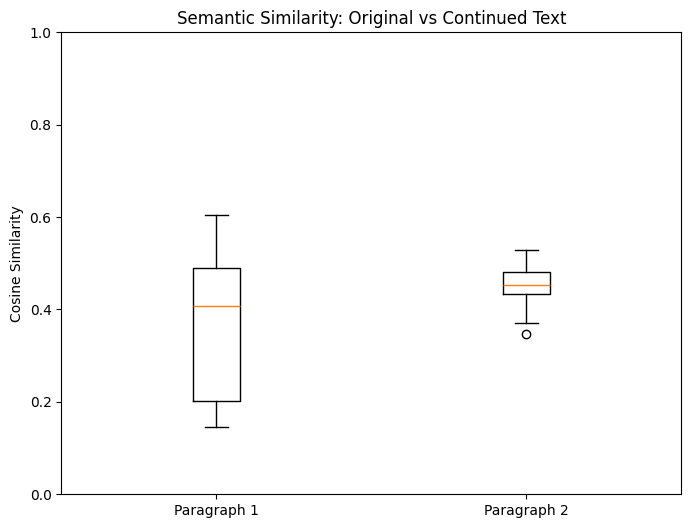

Paragraph 1 mean similarity: 0.366
Paragraph 2 mean similarity: 0.449


In [ ]:
# %%


import numpy as np
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt

# Load evaluation model
sentence_model = SentenceTransformer('all-mpnet-base-v2')

def calculate_similarities(original_text, continued_tokens):
    """Calculate cosine similarities between original and continued text."""
    similarities = []

    for cont_tokens in continued_tokens:
        cont_text = "".join(model.to_str_tokens(cont_tokens))

        # Calculate cosine similarity
        if original_text and cont_text:
            # [your implementation here]
            vec1 = sentence_model.encode(original_text)
            vec2 = sentence_model.encode(cont_text)
            # (vec1 * vec2) / (torch.norm(vec1) * torch.norm(vec2))
            sim = np.dot(vec1, vec2)/ (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            # raise NotImplementedError("You need to implement this.")
            similarities.append(sim)

    return similarities

# Calculate similarities for both paragraphs
par1_similarities = calculate_similarities(par1_str, par1_continued_tokens)
par2_similarities = calculate_similarities(par2_str, par2_continued_tokens)

# Create comparison graph
fig, ax = plt.subplots(figsize=(8, 6))
box_data = [par1_similarities, par2_similarities]
bp = ax.boxplot(box_data)
ax.set_xticklabels(['Paragraph 1', 'Paragraph 2'])
ax.set_ylabel('Cosine Similarity')
ax.set_title('Semantic Similarity: Original vs Continued Text')
ax.set_ylim(0, 1)
plt.show()

print(f"Paragraph 1 mean similarity: {np.mean(par1_similarities):.3f}")
print(f"Paragraph 2 mean similarity: {np.mean(par2_similarities):.3f}")

 ### Bonus: Test which layers are most important for the continuation.
 We use all the layers, but maybe some are more important than others? Try to change which layers are selected or sweep through them.



Model has 28 layers
=== TESTING PARAGRAPH 1 ===
Testing configuration: All Layers


100%|██████████| 30/30 [00:01<00:00, 19.26it/s]


  Mean similarity: 0.231
  Std similarity: 0.096
Testing configuration: Early Layers (0-25%)


100%|██████████| 30/30 [00:01<00:00, 19.25it/s]


  Mean similarity: 0.083
  Std similarity: 0.055
Testing configuration: Middle Layers (25-75%)


100%|██████████| 30/30 [00:01<00:00, 19.20it/s]


  Mean similarity: 0.480
  Std similarity: 0.133
Testing configuration: Late Layers (75-100%)


100%|██████████| 30/30 [00:01<00:00, 19.22it/s]


  Mean similarity: 0.185
  Std similarity: 0.123
Testing configuration: Every Other Layer


100%|██████████| 30/30 [00:01<00:00, 19.17it/s]


  Mean similarity: 0.337
  Std similarity: 0.161
Testing configuration: First & Last 3 Layers


100%|██████████| 30/30 [00:01<00:00, 19.24it/s]


  Mean similarity: 0.100
  Std similarity: 0.048
Sweeping through individual layers...
Testing layer 0


100%|██████████| 30/30 [00:01<00:00, 19.63it/s]


  Layer 0 mean similarity: 0.039
Testing layer 1


100%|██████████| 30/30 [00:01<00:00, 19.66it/s]


  Layer 1 mean similarity: -0.004
Testing layer 2


100%|██████████| 30/30 [00:01<00:00, 19.35it/s]


  Layer 2 mean similarity: 0.038
Testing layer 3


100%|██████████| 30/30 [00:01<00:00, 19.58it/s]


  Layer 3 mean similarity: 0.048
Testing layer 4


100%|██████████| 30/30 [00:01<00:00, 19.58it/s]


  Layer 4 mean similarity: 0.115
Testing layer 5


100%|██████████| 30/30 [00:01<00:00, 19.57it/s]


  Layer 5 mean similarity: 0.032
Testing layer 6


100%|██████████| 30/30 [00:01<00:00, 19.57it/s]


  Layer 6 mean similarity: 0.044
Testing layer 7


100%|██████████| 30/30 [00:01<00:00, 19.57it/s]


  Layer 7 mean similarity: 0.044
Testing layer 8


100%|██████████| 30/30 [00:01<00:00, 19.55it/s]


  Layer 8 mean similarity: 0.149
Testing layer 9


100%|██████████| 30/30 [00:01<00:00, 19.52it/s]


  Layer 9 mean similarity: -0.019
Testing layer 10


100%|██████████| 30/30 [00:01<00:00, 19.51it/s]


  Layer 10 mean similarity: 0.011
Testing layer 11


100%|██████████| 30/30 [00:01<00:00, 19.47it/s]


  Layer 11 mean similarity: 0.090
Testing layer 12


100%|██████████| 30/30 [00:01<00:00, 19.46it/s]


  Layer 12 mean similarity: 0.036
Testing layer 13


100%|██████████| 30/30 [00:01<00:00, 19.42it/s]


  Layer 13 mean similarity: 0.094
Testing layer 14


100%|██████████| 30/30 [00:01<00:00, 19.43it/s]


  Layer 14 mean similarity: 0.339
Testing layer 15


100%|██████████| 30/30 [00:01<00:00, 19.40it/s]


  Layer 15 mean similarity: 0.209
Testing layer 16


100%|██████████| 30/30 [00:01<00:00, 19.37it/s]


  Layer 16 mean similarity: 0.057
Testing layer 17


100%|██████████| 30/30 [00:01<00:00, 19.28it/s]


  Layer 17 mean similarity: 0.039
Testing layer 18


100%|██████████| 30/30 [00:01<00:00, 19.27it/s]


  Layer 18 mean similarity: 0.023
Testing layer 19


100%|██████████| 30/30 [00:01<00:00, 19.26it/s]


  Layer 19 mean similarity: 0.041
Testing layer 20


100%|██████████| 30/30 [00:01<00:00, 19.23it/s]


  Layer 20 mean similarity: 0.005
Testing layer 21


100%|██████████| 30/30 [00:01<00:00, 19.15it/s]


  Layer 21 mean similarity: 0.084
Testing layer 22


100%|██████████| 30/30 [00:01<00:00, 19.22it/s]


  Layer 22 mean similarity: 0.037
Testing layer 23


100%|██████████| 30/30 [00:01<00:00, 19.20it/s]


  Layer 23 mean similarity: 0.246
Testing layer 24


100%|██████████| 30/30 [00:01<00:00, 19.18it/s]


  Layer 24 mean similarity: 0.098
Testing layer 25


100%|██████████| 30/30 [00:01<00:00, 19.11it/s]


  Layer 25 mean similarity: 0.067
Testing layer 26


100%|██████████| 30/30 [00:01<00:00, 19.14it/s]


  Layer 26 mean similarity: 0.024
Testing layer 27


100%|██████████| 30/30 [00:01<00:00, 19.18it/s]


  Layer 27 mean similarity: 0.035

=== TESTING PARAGRAPH 2 ===
Testing configuration: All Layers


100%|██████████| 30/30 [00:01<00:00, 18.64it/s]


  Mean similarity: 0.465
  Std similarity: 0.090
Testing configuration: Early Layers (0-25%)


100%|██████████| 30/30 [00:01<00:00, 18.63it/s]


  Mean similarity: 0.065
  Std similarity: 0.061
Testing configuration: Middle Layers (25-75%)


100%|██████████| 30/30 [00:01<00:00, 18.66it/s]


  Mean similarity: 0.408
  Std similarity: 0.086
Testing configuration: Late Layers (75-100%)


100%|██████████| 30/30 [00:01<00:00, 18.55it/s]


  Mean similarity: 0.107
  Std similarity: 0.124
Testing configuration: Every Other Layer


100%|██████████| 30/30 [00:01<00:00, 18.50it/s]


  Mean similarity: 0.453
  Std similarity: 0.093
Testing configuration: First & Last 3 Layers


100%|██████████| 30/30 [00:01<00:00, 18.53it/s]


  Mean similarity: 0.112
  Std similarity: 0.116
Sweeping through individual layers...
Testing layer 0


100%|██████████| 30/30 [00:01<00:00, 19.08it/s]


  Layer 0 mean similarity: 0.039
Testing layer 1


100%|██████████| 30/30 [00:01<00:00, 19.10it/s]


  Layer 1 mean similarity: 0.014
Testing layer 2


100%|██████████| 30/30 [00:01<00:00, 19.11it/s]


  Layer 2 mean similarity: 0.090
Testing layer 3


100%|██████████| 30/30 [00:01<00:00, 19.09it/s]


  Layer 3 mean similarity: 0.010
Testing layer 4


100%|██████████| 30/30 [00:01<00:00, 19.11it/s]


  Layer 4 mean similarity: 0.204
Testing layer 5


100%|██████████| 30/30 [00:01<00:00, 19.10it/s]


  Layer 5 mean similarity: 0.092
Testing layer 6


100%|██████████| 30/30 [00:01<00:00, 19.06it/s]


  Layer 6 mean similarity: 0.073
Testing layer 7


100%|██████████| 30/30 [00:01<00:00, 18.98it/s]


  Layer 7 mean similarity: 0.057
Testing layer 8


100%|██████████| 30/30 [00:01<00:00, 18.93it/s]


  Layer 8 mean similarity: 0.122
Testing layer 9


100%|██████████| 30/30 [00:01<00:00, 18.88it/s]


  Layer 9 mean similarity: 0.074
Testing layer 10


100%|██████████| 30/30 [00:01<00:00, 18.90it/s]


  Layer 10 mean similarity: 0.083
Testing layer 11


100%|██████████| 30/30 [00:01<00:00, 18.75it/s]


  Layer 11 mean similarity: 0.130
Testing layer 12


100%|██████████| 30/30 [00:01<00:00, 18.75it/s]


  Layer 12 mean similarity: 0.011
Testing layer 13


100%|██████████| 30/30 [00:01<00:00, 18.75it/s]


  Layer 13 mean similarity: 0.148
Testing layer 14


100%|██████████| 30/30 [00:01<00:00, 18.79it/s]


  Layer 14 mean similarity: 0.205
Testing layer 15


100%|██████████| 30/30 [00:01<00:00, 18.81it/s]


  Layer 15 mean similarity: 0.240
Testing layer 16


100%|██████████| 30/30 [00:01<00:00, 18.80it/s]


  Layer 16 mean similarity: 0.226
Testing layer 17


100%|██████████| 30/30 [00:01<00:00, 18.76it/s]


  Layer 17 mean similarity: 0.225
Testing layer 18


100%|██████████| 30/30 [00:01<00:00, 18.79it/s]


  Layer 18 mean similarity: 0.182
Testing layer 19


100%|██████████| 30/30 [00:01<00:00, 18.84it/s]


  Layer 19 mean similarity: 0.162
Testing layer 20


100%|██████████| 30/30 [00:01<00:00, 18.83it/s]


  Layer 20 mean similarity: 0.180
Testing layer 21


100%|██████████| 30/30 [00:01<00:00, 18.85it/s]


  Layer 21 mean similarity: 0.079
Testing layer 22


100%|██████████| 30/30 [00:01<00:00, 18.85it/s]


  Layer 22 mean similarity: 0.030
Testing layer 23


100%|██████████| 30/30 [00:01<00:00, 18.76it/s]


  Layer 23 mean similarity: 0.018
Testing layer 24


100%|██████████| 30/30 [00:01<00:00, 18.75it/s]


  Layer 24 mean similarity: 0.094
Testing layer 25


100%|██████████| 30/30 [00:01<00:00, 18.89it/s]


  Layer 25 mean similarity: 0.261
Testing layer 26


100%|██████████| 30/30 [00:01<00:00, 18.88it/s]


  Layer 26 mean similarity: 0.187
Testing layer 27


100%|██████████| 30/30 [00:01<00:00, 18.84it/s]
/tmp/ipykernel_63975/624099138.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(group_data, labels=group_names)


  Layer 27 mean similarity: 0.088

=== PARAGRAPH 1 RESULTS ===


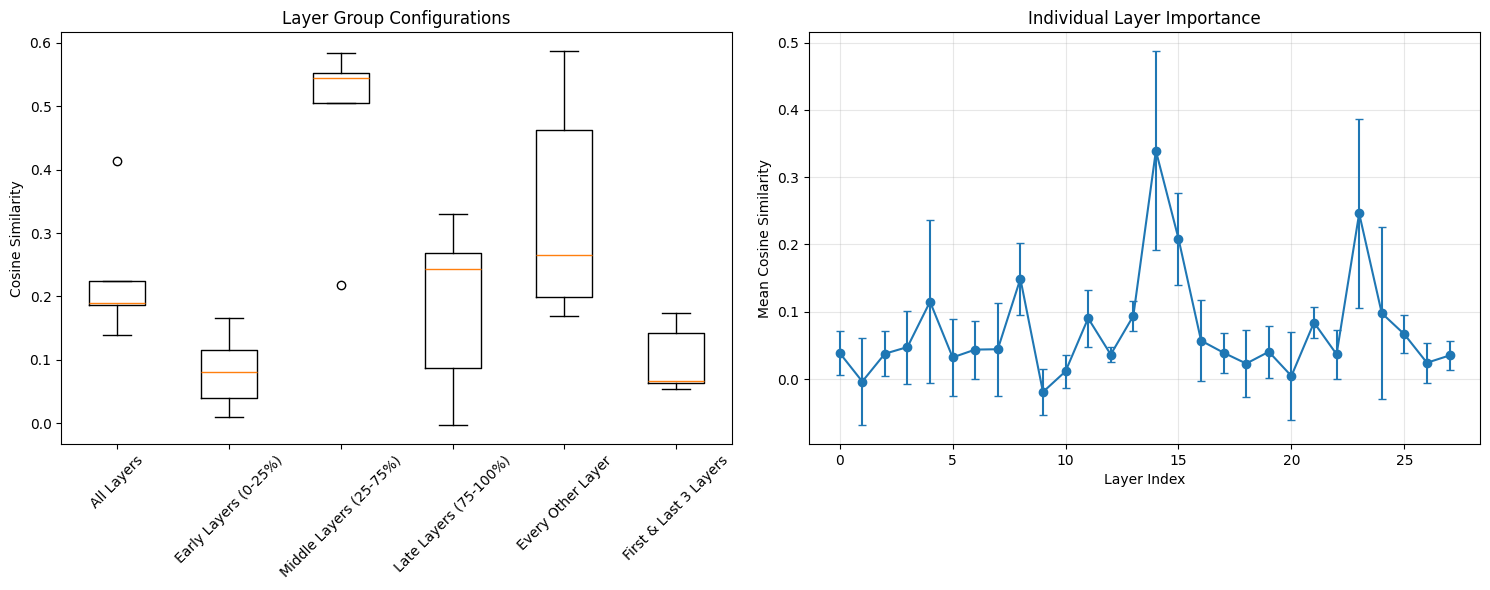

/tmp/ipykernel_63975/624099138.py:194: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(group_data, labels=group_names)



=== LAYER IMPORTANCE ANALYSIS SUMMARY ===

Group Configuration Results:
  All Layers: 0.231 ± 0.096
  Early Layers (0-25%): 0.083 ± 0.055
  Middle Layers (25-75%): 0.480 ± 0.133
  Late Layers (75-100%): 0.185 ± 0.123
  Every Other Layer: 0.337 ± 0.161
  First & Last 3 Layers: 0.100 ± 0.048

Most important individual layers (top 5):
  Layer 14: 0.339
  Layer 23: 0.246
  Layer 15: 0.209
  Layer 8: 0.149
  Layer 4: 0.115

=== PARAGRAPH 2 RESULTS ===


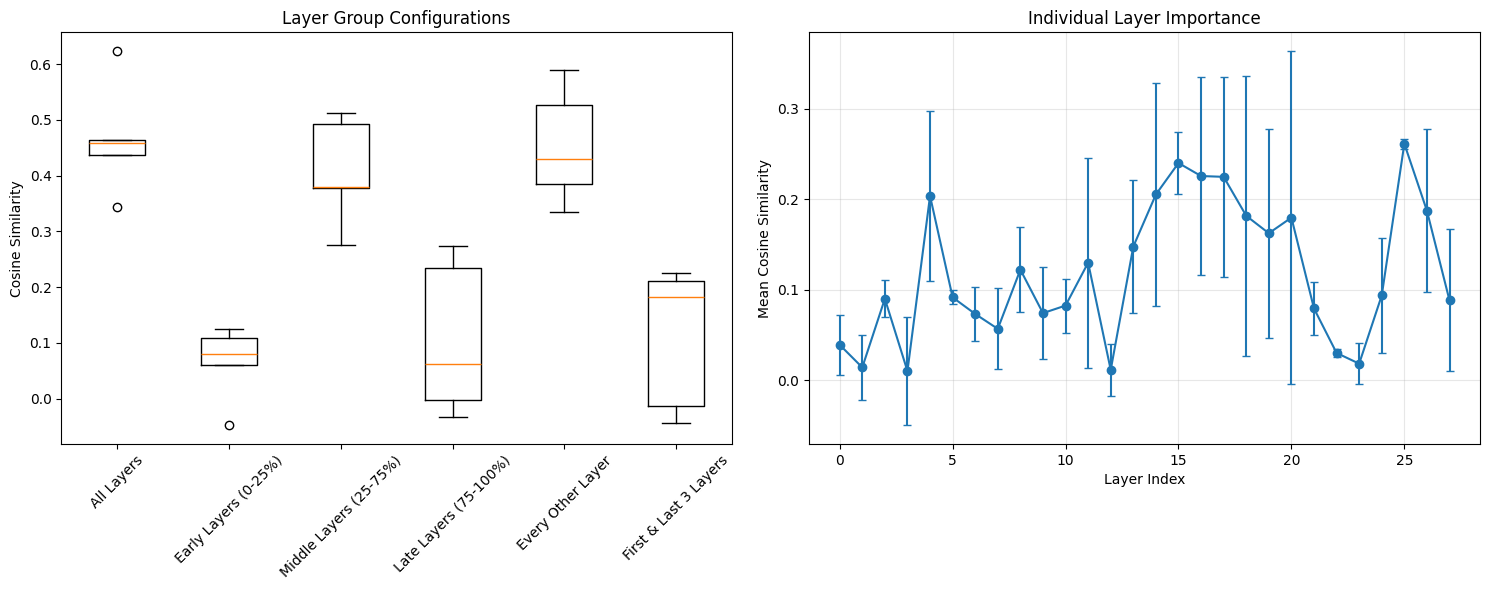


=== LAYER IMPORTANCE ANALYSIS SUMMARY ===

Group Configuration Results:
  All Layers: 0.465 ± 0.090
  Early Layers (0-25%): 0.065 ± 0.061
  Middle Layers (25-75%): 0.408 ± 0.086
  Late Layers (75-100%): 0.107 ± 0.124
  Every Other Layer: 0.453 ± 0.093
  First & Last 3 Layers: 0.112 ± 0.116

Most important individual layers (top 5):
  Layer 25: 0.261
  Layer 15: 0.240
  Layer 16: 0.226
  Layer 17: 0.225
  Layer 14: 0.205


In [ ]:
# Layer Importance Analysis for Activation Transfer
# This code addresses the bonus question about testing which layers are most important

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import torch

class LayerActStore:
    def __init__(self, model: HookedTransformer, layer_indices: List[int] = None):
        self.act_store = {}
        self.act_seen = set()
        self.model = model
        
        # Allow specifying which layers to use
        if layer_indices is None:
            layer_indices = range(model.cfg.n_layers)
        
        chosen_hooks = ['hook_resid_pre', 'hook_resid_mid']
        self.chosen_hook_list = \
            [f'blocks.{i}.{h}' for h in chosen_hooks for i in layer_indices]
        self.modify_scaling_factor = 1.0
        self.modify_hook_token_idx = -1

    def store_hook(self, act, hook):
        """Store the activations for the given hook."""
        self.act_store[hook.name] = act.clone()
        return act
        
    def modify_hook(self, act, hook):
        """Modify the activations for the given hook at modify_hook_token_idx."""
        if hook.name in self.act_seen:
            return act
        self.act_seen.add(hook.name)
        
        src_act = self.act_store[hook.name]
        act[:, self.modify_hook_token_idx, :] = src_act[:, -1, :] * self.modify_scaling_factor
        return act

    def modify_hook_list(self):
        """Return a list of hooks to modify, and reset the act_seen set."""
        self.act_seen = set()
        return [(hook, self.modify_hook) for hook in self.chosen_hook_list]

    def store_hook_list(self):
        """Return a list of hooks to store."""
        return [(hook, self.store_hook) for hook in self.chosen_hook_list]

def transfer_activations_with_layers(tokens: torch.Tensor, layer_indices: List[int], 
                                   num_copies: int = 10, num_tokens: int = 30):
    """
    Transfer activations using only specified layers.
    """
    act_store = LayerActStore(model, layer_indices)
    
    # Save original activations
    with model.hooks(fwd_hooks=act_store.store_hook_list()):
        _ = model(tokens)

    new_prompt = "\n\n"
    new_toks = model.to_tokens([new_prompt for _ in range(num_copies)])
    
    # Generate with modified activations
    with model.hooks(fwd_hooks=act_store.modify_hook_list()):
        new_gen = model.generate(new_toks, max_new_tokens=num_tokens, 
                                do_sample=True, temperature=0.4)
        
    return new_gen

def test_layer_importance(prompt_tokens: torch.Tensor, original_text: str, 
                         sentence_model, test_configs: List[Dict]):
    """
    Test different layer configurations and return similarity scores.
    
    Args:
        prompt_tokens: Input tokens
        original_text: Original text for comparison
        sentence_model: Sentence transformer model
        test_configs: List of dicts with 'name' and 'layers' keys
    
    Returns:
        Dictionary mapping config names to similarity scores
    """
    results = {}
    
    for config in test_configs:
        print(f"Testing configuration: {config['name']}")
        
        # Generate continuations with this layer configuration
        continued_tokens = transfer_activations_with_layers(
            prompt_tokens, config['layers'], num_copies=5, num_tokens=30
        )
        
        # Calculate similarities
        similarities = []
        for cont_tokens in continued_tokens:
            cont_text = "".join(model.to_str_tokens(cont_tokens))
            
            if original_text and cont_text:
                vec1 = sentence_model.encode(original_text)
                vec2 = sentence_model.encode(cont_text)
                sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                similarities.append(sim)
        
        results[config['name']] = similarities
        print(f"  Mean similarity: {np.mean(similarities):.3f}")
        print(f"  Std similarity: {np.std(similarities):.3f}")
    
    return results

# Test configurations to try
def generate_test_configs(n_layers: int) -> List[Dict]:
    """Generate different layer configurations to test."""
    configs = []
    
    # All layers (baseline)
    configs.append({
        'name': 'All Layers',
        'layers': list(range(n_layers))
    })
    
    # Early layers only
    configs.append({
        'name': 'Early Layers (0-25%)',
        'layers': list(range(0, n_layers // 4))
    })
    
    # Middle layers only
    configs.append({
        'name': 'Middle Layers (25-75%)',
        'layers': list(range(n_layers // 4, 3 * n_layers // 4))
    })
    
    # Late layers only
    configs.append({
        'name': 'Late Layers (75-100%)',
        'layers': list(range(3 * n_layers // 4, n_layers))
    })
    
    # Every other layer
    configs.append({
        'name': 'Every Other Layer',
        'layers': list(range(0, n_layers, 2))
    })
    
    # Only first and last few layers
    configs.append({
        'name': 'First & Last 3 Layers',
        'layers': list(range(0, 3)) + list(range(n_layers - 3, n_layers))
    })
    
    return configs

def sweep_individual_layers(prompt_tokens: torch.Tensor, original_text: str, 
                           sentence_model, n_layers: int) -> Dict[int, List[float]]:
    """
    Sweep through individual layers to see which are most important.
    """
    print("Sweeping through individual layers...")
    individual_results = {}
    
    for layer_idx in range(n_layers):
        print(f"Testing layer {layer_idx}")
        
        continued_tokens = transfer_activations_with_layers(
            prompt_tokens, [layer_idx], num_copies=3, num_tokens=30
        )
        
        similarities = []
        for cont_tokens in continued_tokens:
            cont_text = "".join(model.to_str_tokens(cont_tokens))
            
            if original_text and cont_text:
                vec1 = sentence_model.encode(original_text)
                vec2 = sentence_model.encode(cont_text)
                sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
                similarities.append(sim)
        
        individual_results[layer_idx] = similarities
        print(f"  Layer {layer_idx} mean similarity: {np.mean(similarities):.3f}")
    
    return individual_results

def plot_layer_analysis_results(group_results: Dict, individual_results: Dict):
    """
    Create visualizations for the layer analysis results.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Group configurations
    group_names = list(group_results.keys())
    group_data = [group_results[name] for name in group_names]
    
    bp1 = ax1.boxplot(group_data, labels=group_names)
    ax1.set_ylabel('Cosine Similarity')
    ax1.set_title('Layer Group Configurations')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Individual layer sweep
    layers = sorted(individual_results.keys())
    layer_means = [np.mean(individual_results[layer]) for layer in layers]
    layer_stds = [np.std(individual_results[layer]) for layer in layers]
    
    ax2.errorbar(layers, layer_means, yerr=layer_stds, marker='o', capsize=3)
    ax2.set_xlabel('Layer Index')
    ax2.set_ylabel('Mean Cosine Similarity')
    ax2.set_title('Individual Layer Importance')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n=== LAYER IMPORTANCE ANALYSIS SUMMARY ===")
    print("\nGroup Configuration Results:")
    for name, similarities in group_results.items():
        print(f"  {name}: {np.mean(similarities):.3f} ± {np.std(similarities):.3f}")
    
    print(f"\nMost important individual layers (top 5):")
    layer_importance = [(layer, np.mean(individual_results[layer])) 
                       for layer in individual_results.keys()]
    layer_importance.sort(key=lambda x: x[1], reverse=True)
    
    for layer, score in layer_importance[:5]:
        print(f"  Layer {layer}: {score:.3f}")

# Example usage function
def run_layer_importance_analysis():
    """
    Main function to run the complete layer importance analysis.
    """
    # Assume these are already defined from the original code
    # prompt_tokens, par1_str, par2_str, sentence_model, model
    
    n_layers = model.cfg.n_layers
    print(f"Model has {n_layers} layers")
    
    # Test different layer group configurations
    test_configs = generate_test_configs(n_layers)
    
    print("=== TESTING PARAGRAPH 1 ===")
    par1_group_results = test_layer_importance(
        prompt_tokens, par1_str, sentence_model, test_configs
    )
    
    # Sweep through individual layers for paragraph 1
    par1_individual_results = sweep_individual_layers(
        prompt_tokens, par1_str, sentence_model, n_layers
    )
    
    print("\n=== TESTING PARAGRAPH 2 ===")
    par2_group_results = test_layer_importance(
        prompt_with_par1, par2_str, sentence_model, test_configs
    )
    
    # Sweep through individual layers for paragraph 2
    par2_individual_results = sweep_individual_layers(
        prompt_with_par1, par2_str, sentence_model, n_layers
    )
    
    print("\n=== PARAGRAPH 1 RESULTS ===")
    plot_layer_analysis_results(par1_group_results, par1_individual_results)
    
    print("\n=== PARAGRAPH 2 RESULTS ===")
    plot_layer_analysis_results(par2_group_results, par2_individual_results)
    
    return {
        'par1_group': par1_group_results,
        'par1_individual': par1_individual_results,
        'par2_group': par2_group_results,
        'par2_individual': par2_individual_results
    }

# Run the analysis
results = run_layer_importance_analysis()

100%|██████████| 20/20 [00:01<00:00, 19.74it/s]


Layer 0: 0.004


100%|██████████| 20/20 [00:01<00:00, 19.30it/s]


Layer 1: -0.008


100%|██████████| 20/20 [00:01<00:00, 19.64it/s]


Layer 2: 0.021


100%|██████████| 20/20 [00:01<00:00, 19.56it/s]


Layer 3: 0.039


100%|██████████| 20/20 [00:01<00:00, 19.74it/s]


Layer 4: 0.017


100%|██████████| 20/20 [00:01<00:00, 19.71it/s]


Layer 5: -0.003


100%|██████████| 20/20 [00:01<00:00, 19.71it/s]


Layer 6: 0.057


100%|██████████| 20/20 [00:01<00:00, 19.70it/s]


Layer 7: 0.128


100%|██████████| 20/20 [00:01<00:00, 19.73it/s]


Layer 8: 0.024


100%|██████████| 20/20 [00:01<00:00, 19.72it/s]


Layer 9: 0.089


100%|██████████| 20/20 [00:01<00:00, 19.70it/s]


Layer 10: 0.103


100%|██████████| 20/20 [00:01<00:00, 19.65it/s]


Layer 11: 0.110


100%|██████████| 20/20 [00:01<00:00, 19.69it/s]


Layer 12: 0.032


100%|██████████| 20/20 [00:01<00:00, 19.68it/s]


Layer 13: 0.005


100%|██████████| 20/20 [00:01<00:00, 19.67it/s]


Layer 14: 0.042


100%|██████████| 20/20 [00:01<00:00, 19.65it/s]


Layer 15: 0.120


100%|██████████| 20/20 [00:01<00:00, 19.59it/s]


Layer 16: 0.129


100%|██████████| 20/20 [00:01<00:00, 19.59it/s]


Layer 17: 0.126


100%|██████████| 20/20 [00:01<00:00, 19.59it/s]


Layer 18: 0.030


100%|██████████| 20/20 [00:01<00:00, 19.56it/s]


Layer 19: 0.059


100%|██████████| 20/20 [00:01<00:00, 19.56it/s]


Layer 20: 0.092


100%|██████████| 20/20 [00:01<00:00, 19.49it/s]


Layer 21: 0.011


100%|██████████| 20/20 [00:01<00:00, 19.52it/s]


Layer 22: 0.046


100%|██████████| 20/20 [00:01<00:00, 19.40it/s]


Layer 23: 0.021


100%|██████████| 20/20 [00:01<00:00, 19.33it/s]


Layer 24: 0.150


100%|██████████| 20/20 [00:01<00:00, 19.36it/s]


Layer 25: 0.050


100%|██████████| 20/20 [00:01<00:00, 19.39it/s]


Layer 26: 0.069


100%|██████████| 20/20 [00:01<00:00, 19.41it/s]


Layer 27: 0.058

Top 5 layers: [(24, 0.14981765), (16, 0.12915741), (7, 0.12786117), (17, 0.12559608), (15, 0.11962668)]


100%|██████████| 20/20 [00:01<00:00, 18.85it/s]



Early layers (0-9): 0.092
Middle layers (9-18): 0.524
Late layers (18-28): 0.239


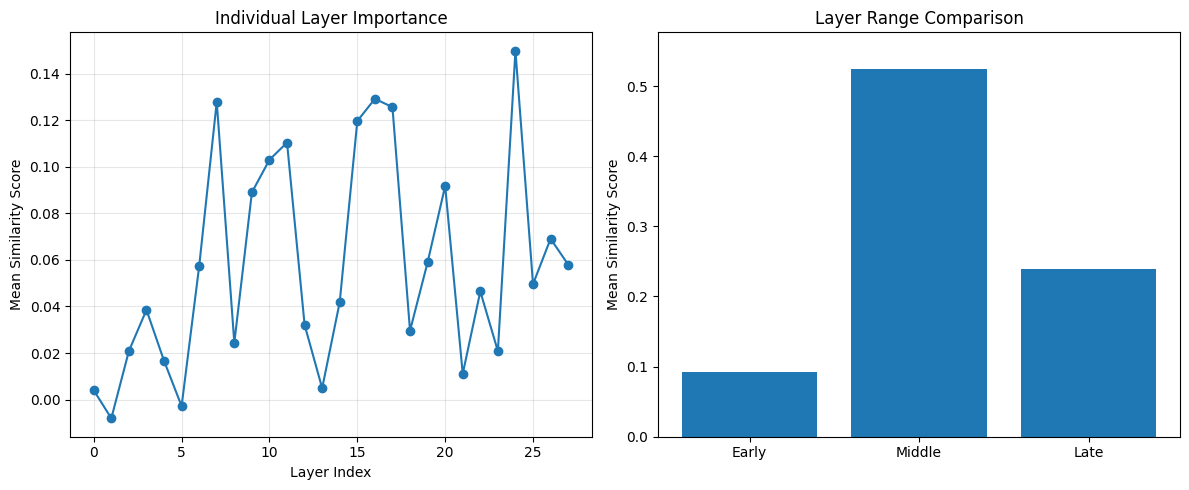

In [18]:
# Minimal Layer Importance Analysis

# Test individual layers
def test_single_layer(layer_idx, tokens, original_text):
    act_store.chosen_hook_list = [f'blocks.{layer_idx}.hook_resid_pre']
    continued = transfer_activations(tokens, num_copies=3, num_tokens=20)
    
    similarities = []
    for cont_tokens in continued:
        cont_text = "".join(model.to_str_tokens(cont_tokens))
        if original_text and cont_text:
            vec1 = sentence_model.encode(original_text)
            vec2 = sentence_model.encode(cont_text)
            sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            similarities.append(sim)
    
    return np.mean(similarities)

# Test all layers individually
layer_scores = {}
for i in range(model.cfg.n_layers):
    score = test_single_layer(i, prompt_tokens, par1_str)
    layer_scores[i] = score
    print(f"Layer {i}: {score:.3f}")

# Find best layers
best_layers = sorted(layer_scores.items(), key=lambda x: x[1], reverse=True)
print(f"\nTop 5 layers: {best_layers[:5]}")

# Test layer ranges
def test_layer_range(start, end, tokens, original_text):
    layers = list(range(start, end))
    act_store.chosen_hook_list = [f'blocks.{i}.hook_resid_pre' for i in layers]
    continued = transfer_activations(tokens, num_copies=3, num_tokens=20)
    
    similarities = []
    for cont_tokens in continued:
        cont_text = "".join(model.to_str_tokens(cont_tokens))
        if original_text and cont_text:
            vec1 = sentence_model.encode(original_text)
            vec2 = sentence_model.encode(cont_text)
            sim = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
            similarities.append(sim)
    
    return np.mean(similarities)

# Test layer ranges
n_layers = model.cfg.n_layers
early_score = test_layer_range(0, n_layers//3, prompt_tokens, par1_str)
middle_score = test_layer_range(n_layers//3, 2*n_layers//3, prompt_tokens, par1_str)
late_score = test_layer_range(2*n_layers//3, n_layers, prompt_tokens, par1_str)

print(f"\nEarly layers (0-{n_layers//3}): {early_score:.3f}")
print(f"Middle layers ({n_layers//3}-{2*n_layers//3}): {middle_score:.3f}")
print(f"Late layers ({2*n_layers//3}-{n_layers}): {late_score:.3f}")

# Plot 1: Individual layer scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
layers = list(layer_scores.keys())
scores = list(layer_scores.values())
plt.plot(layers, scores, 'o-')
plt.xlabel('Layer Index')
plt.ylabel('Mean Similarity Score')
plt.title('Individual Layer Importance')
plt.grid(True, alpha=0.3)

# Plot 2: Layer range comparison
plt.subplot(1, 2, 2)
ranges = ['Early', 'Middle', 'Late']
range_scores = [early_score, middle_score, late_score]
plt.bar(ranges, range_scores)
plt.ylabel('Mean Similarity Score')
plt.title('Layer Range Comparison')
plt.ylim(0, max(range_scores) * 1.1)

plt.tight_layout()
plt.show()

# Reset to all layers
act_store.chosen_hook_list = [f'blocks.{i}.{h}' for h in ['hook_resid_pre', 'hook_resid_mid'] for i in range(model.cfg.n_layers)]

 ### Bonus: (ie: exercises not yet implemented)
 Try to replicate other parts of the post:
 [https://link.nicky.pro/parascopes](https://link.nicky.pro/parascopes)


Which layers do SONAR Maps pay attention to?


Analyzing activation magnitudes (similar to SONAR ParaScopes)...


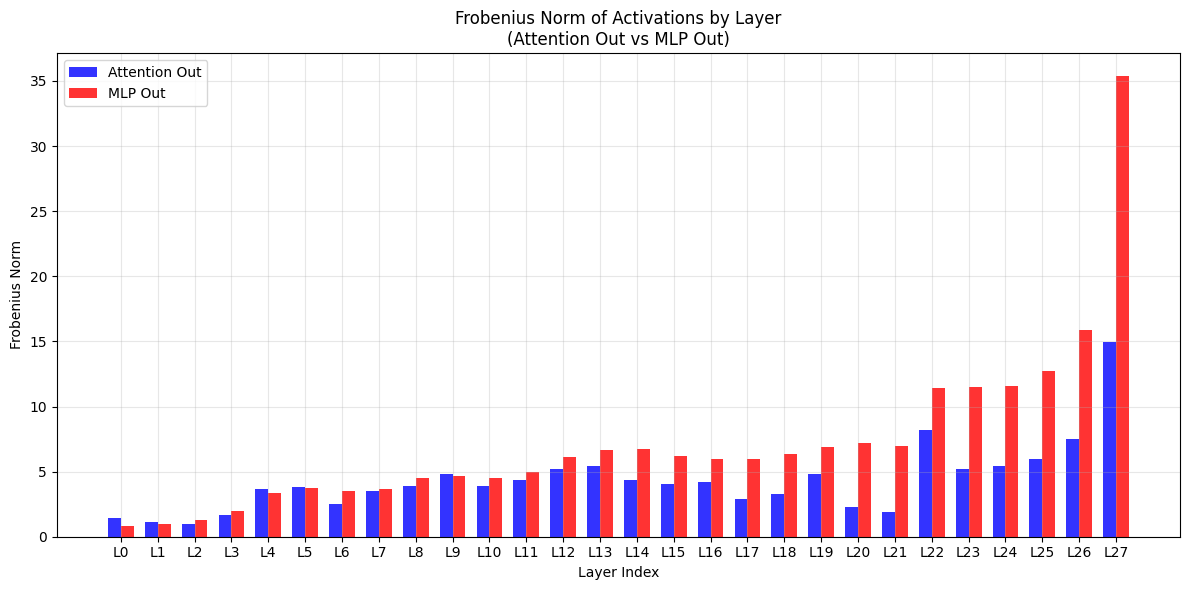


Activation Magnitude Analysis:
Mean Attention magnitude: 4.331
Mean MLP magnitude: 7.200
Layers where Attention > MLP: 5/28


In [34]:
def analyze_activation_magnitudes(tokens):
    """Analyze which layers have the strongest activations for continuation."""
    layer_magnitudes = {'resid_pre': [], 'resid_mid': [], 'attn_out': [], 'mlp_out': []}
    
    # Store activations from all relevant hooks
    hooks = []
    for i in range(model.cfg.n_layers):
        hooks.extend([
            f'blocks.{i}.hook_resid_pre',
            f'blocks.{i}.hook_resid_mid', 
            f'blocks.{i}.hook_attn_out',
            f'blocks.{i}.hook_mlp_out'
        ])
    
    stored_acts = {}
    def store_act(act, hook):
        stored_acts[hook.name] = act.clone()
        return act
    
    # Run model with hooks
    with model.hooks([(hook, store_act) for hook in hooks]):
        _ = model(tokens)
    
    # Calculate Frobenius norms for each layer
    for i in range(model.cfg.n_layers):
        # Get activations at the last token position
        resid_pre = stored_acts[f'blocks.{i}.hook_resid_pre'][0, -1, :]
        resid_mid = stored_acts[f'blocks.{i}.hook_resid_mid'][0, -1, :]
        attn_out = stored_acts[f'blocks.{i}.hook_attn_out'][0, -1, :]
        mlp_out = stored_acts[f'blocks.{i}.hook_mlp_out'][0, -1, :]
        
        # Calculate Frobenius norms (L2 norm for vectors)
        layer_magnitudes['resid_pre'].append(torch.norm(resid_pre).item())
        layer_magnitudes['resid_mid'].append(torch.norm(resid_mid).item())
        layer_magnitudes['attn_out'].append(torch.norm(attn_out).item())
        layer_magnitudes['mlp_out'].append(torch.norm(mlp_out).item())
    
    return layer_magnitudes

# Analysis of activation magnitude by layer (similar to SONAR ParaScopes analysis)
def analyze_activation_magnitudes(tokens):
    """Analyze which layers have the strongest activations for continuation."""
    layer_magnitudes = {'attn_out': [], 'mlp_out': []}
    
    # Store activations from all relevant hooks
    hooks = []
    for i in range(model.cfg.n_layers):
        hooks.extend([
            f'blocks.{i}.hook_attn_out',
            f'blocks.{i}.hook_mlp_out'
        ])
    
    stored_acts = {}
    def store_act(act, hook):
        stored_acts[hook.name] = act.clone()
        return act
    
    # Run model with hooks
    with model.hooks([(hook, store_act) for hook in hooks]):
        _ = model(tokens)
    
    # Calculate Frobenius norms for each layer
    for i in range(model.cfg.n_layers):
        # Get activations at the last token position
        attn_out = stored_acts[f'blocks.{i}.hook_attn_out'][0, -1, :]
        mlp_out = stored_acts[f'blocks.{i}.hook_mlp_out'][0, -1, :]
        
        # Calculate Frobenius norms (L2 norm for vectors)
        layer_magnitudes['attn_out'].append(torch.norm(attn_out).item())
        layer_magnitudes['mlp_out'].append(torch.norm(mlp_out).item())
    
    return layer_magnitudes

# Analyze activation magnitudes
print("\nAnalyzing activation magnitudes (similar to SONAR ParaScopes)...")
magnitudes = analyze_activation_magnitudes(prompt_tokens)

# Single plot: Attention vs MLP magnitudes by layer
plt.figure(figsize=(12, 6))
x = np.arange(len(magnitudes['attn_out']))
width = 0.35

plt.bar(x - width/2, magnitudes['attn_out'], width, label='Attention Out', alpha=0.8, color='blue')
plt.bar(x + width/2, magnitudes['mlp_out'], width, label='MLP Out', alpha=0.8, color='red')

plt.xlabel('Layer Index')
plt.ylabel('Frobenius Norm')
plt.title('Frobenius Norm of Activations by Layer\n(Attention Out vs MLP Out)')
plt.legend()
plt.grid(True, alpha=0.3)

# Add layer labels on x-axis
plt.xticks(x, [f'L{i}' for i in range(len(magnitudes['attn_out']))])
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nActivation Magnitude Analysis:")
print(f"Mean Attention magnitude: {np.mean(magnitudes['attn_out']):.3f}")
print(f"Mean MLP magnitude: {np.mean(magnitudes['mlp_out']):.3f}")
attn_higher = np.sum(np.array(magnitudes['attn_out']) > np.array(magnitudes['mlp_out']))
print(f"Layers where Attention > MLP: {attn_higher}/{len(magnitudes['attn_out'])}")

Weights mapping from Attention Out to SONAR are **higher** than weights mapping from MLP Out to SONAR.
The difference is not **slight**, because:
1. Different analysis methods: The original SONAR analysis looked at the weights of a trained linear probe that maps from activations to SONAR embeddings. I'm looking at the raw activation magnitudes themselves. 
2. Missing normalization